## Random Time Version

### Theorem

Denote $\phi^T(t)$ be the probability of a person getting cancer before time $T-t$ (condition same as in simulation, start with 0 age, 0 mutation and end at time $T-t$). $q_G^T(t)$ the same as in your theory (where $T$ is the total time). 

Let $T_1$ be the hit time of first mutation, we may assume it follows a Gamma distribution (simulations seem to be far away from an exponential distribution). But here we only use the empirical distribution from simulation data. Also, from the simulated data, we will assume that only when first mutation is $F$ the patient will get cancer and the conditional probability to get "F" is 1/3.

Let $T_2$ be the time for the mutated cell to grow to size $\epsilon K$ condition on the cell population will survive. Then we use the same approximation as in your theorem, which is $f_{T_2}(t) = \frac{r^2 e^{-rt} \epsilon K}{b} \exp\left( -\frac{re^{-rt}\epsilon K}{b} \right)$. And the survival probability is $\frac{r}{b}$.

Then we have:
$$\phi^T(t) = \frac{1}{3} E\left[ \frac{r_{F}}{b_{F}} (1-q^T_F(t+T_1+T_2)) \right]$$

which is 
$$\phi^T(t) = \frac{1}{3|T_1|}\sum_{T_1}\int \frac{r_{F}}{b_{F}} (1-q^T_F(t+T_1+t_2)) f_{T_2}(t_2) dt_2$$


### Experiment

In [88]:
from theorem import *

%matplotlib inline

alpha = {"division":1.75, "death":0, "pasym":0.9, "psym":0.0525, "dsym":0.1-0.0525,
         "adjust":1.5e-2, "v":1e-6, "K":10**9.3, "dd":1.14794853, "dp":2.12*1e-3, "dm":5*1e-6,
         "l_ratio":0.15/(1.6+0.15), "pow":0.4117, "eps":1e-6}

test = tissue(alpha, pGUfunc, 52*80,52*80*10, Gene="F")
density = test.density(test.ts, test.para)
print(np.sum(test.ts/52 * density/10))
print(test.para)

Excess Survival ratio: 0.003343594606361718
P(mutiation in [0,tao]): 0.007400384850753561
9.473556190541384
{'b': 0.095585, 'd': 0.08312500000000002, 'r': 0.012459999999999985, 'K': 1995262314.9688828, 'G': 'F', 'va': 7.5e-09, 'vs': 1.5e-08, 'v': 7.5534e-09}


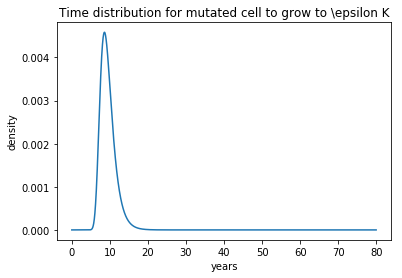

In [89]:
plt.plot(test.ts/52, density, label='Line 1')
plt.xlabel("years")
plt.ylabel("density")
plt.title("Time distribution for mutated cell to grow to \epsilon K")
plt.show()

In [90]:
r_F = test.para["r"]
b_F = test.para["b"]
print("Survial Probability for mutated cell:", r_F/b_F)
solution = test.solve()

Survial Probability for mutated cell: 0.13035518125228837
Begin Solving
F  FS  FSS  FSF  FSM  FF  FFS  FFF  FFM  FM  FMS  FMF  FMM  
Done


Here's the empirical distribution for HitTime1

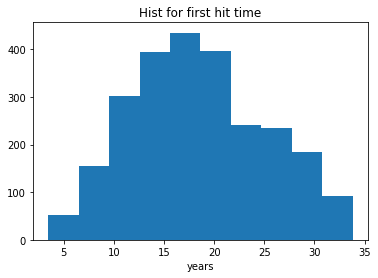

In [91]:
import pandas as pd

result = pd.read_csv("result.csv")
hit1 = np.array(pd.to_numeric(result[' HitTime1'], errors="coerce").to_list())
hit1 = hit1[~np.isnan(hit1)]
plt.hist(hit1/52)
plt.xlabel("years")
plt.title("Hist for first hit time")
plt.show()

In [92]:
import numba as nb

adjust_density = 1/3 * 0.1 * r_F/b_F * density / len(hit1)
solutionF = solution["F"][::10]
adjust_density = adjust_density[::10]*10

@nb.njit 
def aux(solutionF, hit1, adjust_density):
    prob = np.zeros(solutionF.shape[0])
    for i in range(len(solutionF)):
        if i % 400 == 0:
            print(i)
        for t1 in hit1:
            j = int(t1)
            for k, d_t2 in enumerate(adjust_density):
                if i + j + k < len(prob):
                    prob[i] += d_t2 * (1-solutionF[i+j+k])
    print("")
    return prob

prob = aux(solutionF, hit1, adjust_density)

0
400
800
1200
1600
2000
2400
2800
3200
3600
4000



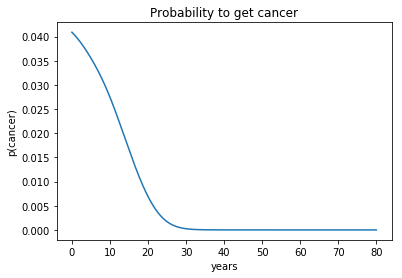

In [94]:
plt.plot(test.ts[::10]/52, prob, label='Line 1')
plt.xlabel("years")
plt.ylabel("p(cancer)")
plt.title("Probability to get cancer")
plt.show() 